In [1]:
import os
import folium
import pandas as pd
import altair as alt
from altair.expr import datum, if_
from neo4j.v1 import GraphDatabase
from folium.plugins import MarkerCluster, FastMarkerCluster

In [2]:
# we need to run this line to use Altair in a Jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
# Altair raises a MaxRowsError exception when passing a dataset with more than 5000 rows.
ALTAIR_LIMIT = 5000
# The limit of 5000 rows can be disabled with this line
# https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

## Data

The original Paradise Papers dataset can be found [here](https://offshoreleaks.icij.org/pages/database).

The dataset is licensed under the [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and its contents under [Creative Commons Attribution-ShareAlike license](https://creativecommons.org/licenses/by-sa/3.0/).

In [4]:
dirpath = os.path.abspath(os.path.join('data', 'csv_paradise_papers.2018-02-14'))
dirpath

'/home/giacomo/repos/paradise-papers-neo4j/data/csv_paradise_papers.2018-02-14'

Since I read the awesome [Data Science at the Command Line](https://www.datascienceatthecommandline.com/), I have always felt the need to have a quick peek at the data with some nifty unix commands.

Let's have a look at the addresses and the edges (i.e. the relationships between two nodes in the graph).

In [5]:
!cd data/csv_paradise_papers.2018-02-14 && ls

paradise_papers.edges.csv	   paradise_papers.nodes.intermediary.csv
paradise_papers.nodes.address.csv  paradise_papers.nodes.officer.csv
paradise_papers.nodes.entity.csv   paradise_papers.nodes.other.csv


In [6]:
!cd data/csv_paradise_papers.2018-02-14 && head -5 paradise_papers.nodes.address.csv

"node_id","name","address","country_codes","countries","sourceID","valid_until","note"
"81014050","6B Chenyu Court; 22-24 Kennedy Road; Hong Kong","6B Chenyu Court","HKG","Hong Kong","Paradise Papers - Appleby","Appleby data is current through 2014",""
"81014052","15C Suchun Industrial Square; Suzhou Industrial Park; 215126 Suzhou; People's Republic of China","15C Suchun Industrial Square","CHN","China","Paradise Papers - Appleby","Appleby data is current through 2014",""
"81014055","8F., No. 68; Minfu 13th St. Taoyuan County; 330; Taiwan","8F., No. 68","TWN","Taiwan","Paradise Papers - Appleby","Appleby data is current through 2014",""
"81014056","No. 66, Ln. 20; Dafu Rd., Shengang Township; 429 Taichung County; Taiwan","No. 66, Ln. 20","TWN","Taiwan","Paradise Papers - Appleby","Appleby data is current through 2014",""


In [7]:
!cd data/csv_paradise_papers.2018-02-14 && head -5 paradise_papers.edges.csv

"START_ID","TYPE","END_ID","link","start_date","end_date","sourceID","valid_until"
"85004927","registered_address","88000379","registered address","","","Paradise Papers - Aruba corporate registry","Aruba corporate registry data is current through 2016"
"85004928","registered_address","88016409","registered address","","","Paradise Papers - Aruba corporate registry","Aruba corporate registry data is current through 2016"
"85004929","registered_address","88005855","registered address","","","Paradise Papers - Aruba corporate registry","Aruba corporate registry data is current through 2016"
"85004929","connected_to","85008101","connected to","","","Paradise Papers - Aruba corporate registry","Aruba corporate registry data is current through 2016"


These CSV files are not that big, and we could import them in a pandas DataFrame easily. However, we would still need to invest some time in data cleaning, like formatting dates and [geocoding](https://en.wikipedia.org/wiki/Geocoding) human-readable addresses into latitude and longitude coordinates.

Luckily enough there is a [Neo4j sandbox](https://neo4j.com/sandbox-v2/) with the data ready to be analyzed and visualized.

We can connect to the sandbox with the official Neo4j Python driver.

In [8]:
driver = GraphDatabase.driver('bolt://165.227.223.190:7687', auth=('ppviz', 'ppviz'))

## Nodes and Relationships

First of all, we need to understand the data model used to build this dataset.

Let's start with **node labels**.

In [9]:
cypher_query = '''
// Find all node labels and how many times they appear in the graph
MATCH (n)
RETURN LABELS(n) AS node_labels, COUNT(*) AS num
ORDER BY num DESC
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df

,node_labels,num
0,[Officer],84266
1,[Address],59833
2,[Entity],24973
3,"[Address, Process]",3700
4,[Other],2004
5,[Intermediary],324


 Let's have a look at the **node properties**.

In [10]:
cypher_query = '''
MATCH (n:Officer)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['_id', 'pagerank_g', 'name', 'node_id']]

[In his tutorial on the Neo4j's blog](https://neo4j.com/blog/analyzing-paradise-papers-neo4j/), William Lyon explains that they used the [Apoc Cypher procedure library](https://neo4j-contrib.github.io/neo4j-apoc-procedures/#_geocode) and the [Google's Geocoding API](https://developers.google.com/maps/documentation/geocoding/start) to geocode the physical address available in the original Paradise Papers dataset.

As we can see, the data from the Neo4j sandbox already contains latitude and longitude.

In [11]:
cypher_query = '''
MATCH (n:Address)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['name',
  'latitude',
  'description',
  'country_codes',
  'node_id',
  'longitude',
  'countries',
  'address',
  'pagerank_g']]

In [12]:
cypher_query = '''
MATCH (n:Entity)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['jurisdiction',
  'name',
  'jurisdiction_description',
  '_id',
  'country_codes',
  'node_id',
  'service_provider',
  'countries',
  'pagerank_g']]

In [13]:
cypher_query = '''
MATCH (n:Process)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['name',
  '_id',
  'country_codes',
  'node_id',
  'countries',
  'address',
  'pagerank_g']]

In [14]:
cypher_query = '''
MATCH (n:Other)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['pagerank_g', 'name', 'node_id', '_id']]

In [15]:
cypher_query = '''
MATCH (n:Intermediary)
RETURN KEYS(n) as node_properties
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.node_properties.values.tolist()

[['jurisdiction',
  'name',
  'jurisdiction_description',
  '_id',
  'node_id',
  'pagerank_g']]

Now let's have a look at the **relationship types**.

In [16]:
cypher_query = '''
// Find all relationship types and how many times they appear in the graph
MATCH ()-[r]->()
RETURN TYPE(r) as relationship_type, COUNT(*) AS num
ORDER BY num DESC
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df[['relationship_type', 'num']]

,relationship_type,num
0,OFFICER_OF,287113
1,REGISTERED_ADDRESS,135367
2,CONNECTED_TO,10552
3,INTERMEDIARY_OF,7134
4,SAME_NAME_AS,418
5,SAME_ID_AS,2


## Explore the dataset with Cypher queries and Altair plots

In [17]:
cypher_query = '''
// What are the top 10 most popular offshore jurisdictions chosen by the legal entities in the dataset?
MATCH (a:Address)<-[:REGISTERED_ADDRESS]-(o:Officer)-[:CONNECTED_TO|OFFICER_OF]->(e:Entity)
RETURN e.jurisdiction_description AS jurisdiction, COUNT(*) AS num
ORDER BY num DESC
LIMIT 10
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df

,jurisdiction,num
0,Bermuda,316665
1,Cayman Islands,69531
2,Isle of Man,27384
3,British Virgin Islands,12460
4,Jersey,11656
5,Mauritius,5885
6,Seychelles,1854
7,Guernsey,747
8,Liechtenstein,744
9,United States of America,548


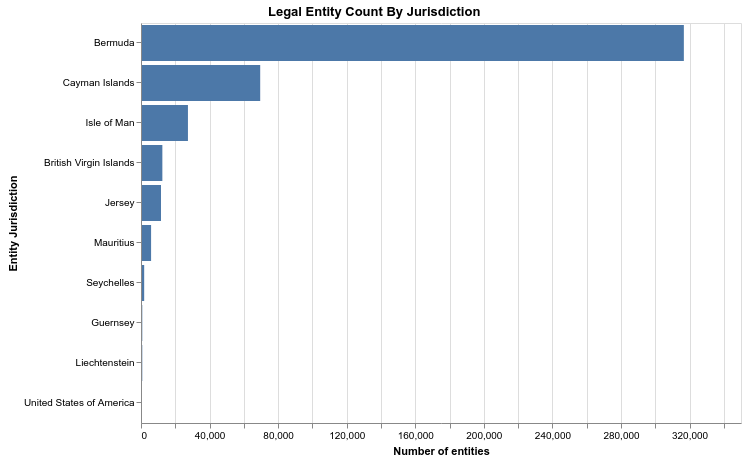

In [18]:
# In Altair, use O for Ordinal data, Q for Quantitative data
alt.Chart(df).mark_bar()\
.encode(
    x=alt.X('num:Q', axis=alt.Axis(title='Number of entities')),
    y=alt.Y('jurisdiction:O', sort=[j for j in df.jurisdiction], axis=alt.Axis(title='Entity Jurisdiction'))
)\
.properties(
    title='Legal Entity Count By Jurisdiction',
    width=600,
    height=400
)

Neo4j v3.4 has some new features that we can use to perform [geospatial queries](https://medium.com/neo4j/whats-new-in-neo4j-spatial-features-586d69cda8d0), but we can't do anything if we don't have latitude and longitude.

Strangely enough, some addresses that look valid were not geocoded.

In [19]:
cypher_query = '''
MATCH (a:Address)
WHERE NOT EXISTS(a.latitude) OR NOT EXISTS(a.longitude)
RETURN a
LIMIT 1
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])
df.a.iloc[0]

<Node id=2 labels={'Address'} properties={'pagerank_g': 0.17550000000000002, 'address': '3rd Floor, Cerné House', 'name': '3rd Floor, Cerné House; La Chaussée; Port Louis; Mauritius', 'country_codes': 'MUS', '_id': '4', 'countries': 'Mauritius', 'node_id': '81000007'}>

When it comes to choosing an offshore jurisdiction for their legal entities, do officers in London, New York and Hong Kong make different choices?

In [20]:
London = {
    'latitude': 51.50853,
    'longitude': -0.12574
}
NewYork = {
    'latitude': 40.730610,
    'longitude': -73.935242
}
HongKong = {
    'latitude': 22.28552,
    'longitude': 114.15769
}

In [21]:
cypher_query = '''
// Geospatial query: find all matches in 100km
MATCH (e:Entity)<-[:CONNECTED_TO|OFFICER_OF]-(o:Officer)-[:REGISTERED_ADDRESS]->(a:Address)
WHERE
  EXISTS(a.latitude) AND
  EXISTS(a.longitude) AND
  DISTANCE(POINT(a), POINT({latitude: $latitude, longitude:$longitude})) < $meters
RETURN DISTINCT
  e.name AS entity,
  e.jurisdiction_description AS jurisdiction,
  e.country_codes AS country_codes,
  a.name AS officer_address
'''
meters = 100000
with driver.session() as session:
    results = session.run(cypher_query, **London, meters=meters)
df_london = pd.DataFrame([d for d in results.data()])

with driver.session() as session:
    results = session.run(cypher_query, **NewYork, meters=meters)
df_ny = pd.DataFrame([d for d in results.data()])

with driver.session() as session:
    results = session.run(cypher_query, **HongKong, meters=meters)
df_hk = pd.DataFrame([d for d in results.data()])

In [22]:
df_london.head()

,country_codes,entity,jurisdiction,officer_address
0,IMN;GBR,The Body Shop (Isle of Man) Limited,Isle of Man,Deerfield House; 114 Second Avenue; Batchmere;...
1,IMN,The Mobileserv Holdco 2 Settlement,Isle of Man,20 Coopers Hill; Willingdon; Eastbourne; Unite...
2,IMN;GBR,The Body Shop (Isle of Man) Limited,Isle of Man,7 Fosters Close; Angmering; West Sussex; Unite...
3,BMU;CYM;USA,"GEROVA Financial Group, Ltd.",Bermuda,44 Gorham Avenue; Rottingdean; Brighton BN2 7D...
4,BMU,GEROVA Reinsurance Ltd.,Bermuda,44 Gorham Avenue; Rottingdean; Brighton BN2 7D...


We can group by jurisdiction. We also reset the index to avoid a [hierarchical index](https://pandas.pydata.org/pandas-docs/stable/advanced.html#hierarchical-indexing-multiindex), which would make plotting more complex.

In [23]:
df_london_grouped = df_london.groupby('jurisdiction')[['entity']].count()\
    .rename(columns={'entity': 'num'})\
    .sort_values(by='num', ascending=False)\
    .reset_index()

df_ny_grouped = df_ny.groupby('jurisdiction')[['entity']].count()\
    .rename(columns={'entity': 'num'})\
    .sort_values(by='num', ascending=False)\
    .reset_index()

df_hk_grouped = df_hk.groupby('jurisdiction')[['entity']].count()\
    .rename(columns={'entity': 'num'})\
    .sort_values(by='num', ascending=False)\
    .reset_index()

We can use a grouped bar chart to show the 5 most popular offshore jurisdictions.

In [24]:
df_london_grouped['city'] = 'London'
df_ny_grouped['city'] = 'New York'
df_hk_grouped['city'] = 'Hong Kong'
N = 5
df_concat = pd.concat([df_london_grouped[:N], df_ny_grouped[:N], df_hk_grouped[:N]])

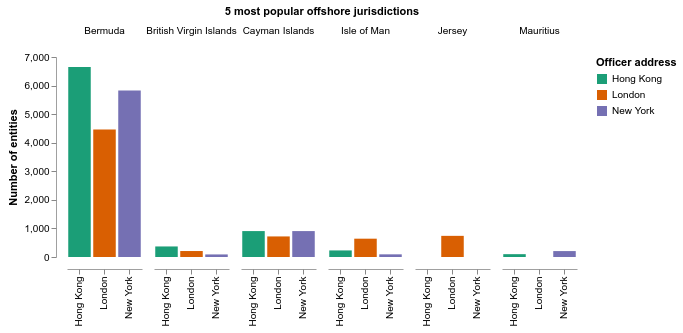

In [25]:
alt.Chart(df_concat).mark_bar(stroke='transparent')\
.encode(
    x=alt.X('city:N', axis=alt.Axis(title=''), scale=alt.Scale(rangeStep=10)),
    y=alt.Y('num:Q', axis=alt.Axis(title='Number of entities', grid=False)),    
    color=alt.Color('city:N', scale=alt.Scale(range=['#1b9e77', '#d95f02', '#7570b3']), title='Officer address'),
    column=alt.Column('jurisdiction:O', title=f'{N} most popular offshore jurisdictions')
).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8,
    # ticks=False
).properties(width=75, height=200)

This Cypher query (took from [William Lyon's tutorial](https://www.lyonwj.com/2017/11/28/geocoding-paradise-papers-neo4j-spatial-visualization/)) will find all registered addresses of Officers in the Paradise Papers dataset (that we were able to geocode), as well as all their connected offshore legal entities.

In [ ]:
%%time
# Sometimes this match fails because it returns too many results (TransientError)
# MATCH (a:Address)<-[:REGISTERED_ADDRESS]-(o:Officer)-[:CONNECTED_TO|OFFICER_OF]-(e:Entity)
# This match always works, but it return only ~300 results
# MATCH (a:Address)<-[:REGISTERED_ADDRESS]-(o:Officer)-[:CONNECTED_TO]-(e:Entity)
cypher_query = '''
MATCH (a:Address)<-[:REGISTERED_ADDRESS]-(o:Officer)-[:CONNECTED_TO|OFFICER_OF]-(e:Entity)
WHERE EXISTS(a.latitude) AND EXISTS(a.longitude)
RETURN
  a.name AS address,
  a.latitude AS latitude,
  a.longitude AS longitude,
  COLLECT(DISTINCT o.name) AS officers,
  COLLECT(DISTINCT e.name) AS entities,
  COLLECT(DISTINCT e.jurisdiction_description) AS jurisdictions,
  1.0*COUNT(*) AS strength
'''
with driver.session() as session:
    results = session.run(cypher_query)
df = pd.DataFrame([d for d in results.data()])

In [42]:
df.shape

(331, 7)

In [43]:
df.describe()

,latitude,longitude,strength
count,331.000000,331.000000,331.000000
mean,37.605545,-8.997428,3.217523
std,20.511699,60.109547,9.900159
min,-36.852482,-123.285495,1.000000
25%,25.084482,-64.783687,1.000000
50%,48.454788,-2.575091,1.000000
75%,52.638352,2.294830,2.000000
max,59.318578,174.779452,117.000000


I wonder why there is such a big difference between the top 1% and the bottom 99% in `strength`...

In [44]:
df_low = df[df.strength < df.strength.quantile(.99)]
df_low.shape

(327, 7)

In [45]:
df_high = df[df.strength >= df.strength.quantile(.99)]
df_high.shape

(4, 7)

It might be interesting to explore the `strength` property with a histogram.

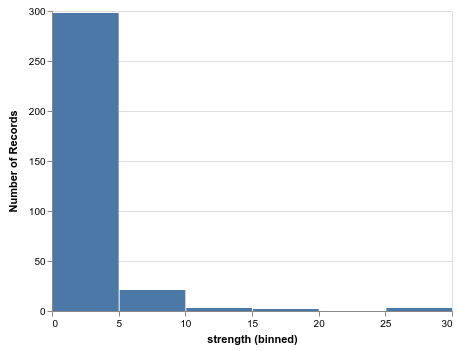

In [46]:
alt.Chart(df_low).mark_bar()\
.encode(
    x=alt.X("strength:Q", bin=True),
    y='count()'
)

Altair's `bin=True` might look very convenient, but [histograms are hard](http://tinlizzie.org/histograms/) and we should always try different bin parameters.

Luckily, Altair allows us to do that too! Replace `bin=True` with `bin=BinParams()`.

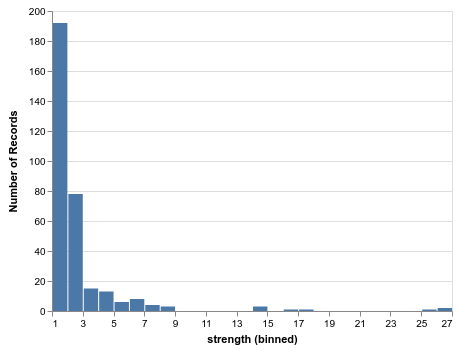

In [47]:
alt.Chart(df_low).mark_bar()\
.encode(
    x=alt.X("strength:Q", bin=alt.BinParams(step=1, nice=True)),
    y='count()',
)

In [48]:
df_top10 = df_high.sort_values(by='strength', ascending=False)[:10]

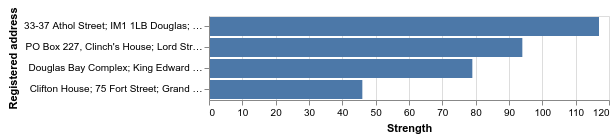

In [49]:
alt.Chart(df_top10).mark_bar()\
.encode(
    x=alt.X('strength:Q', axis=alt.Axis(title='Strength')),
    y=alt.Y('address:O', sort=[s for s in df_top10.strength], axis=alt.Axis(title='Registered address'))
)

## Interactive maps with Folium

We can create a map with [Folium](https://github.com/python-visualization/folium), a library that basically converts our Python code into an interactive [Leaflet.js](https://leafletjs.com/) map.

First, we define a few functions to sanitize the strings and to style the popups.

In [50]:
def sanitize(s):
    return s.replace("'", " ")

In [51]:
def ul_tagify(strings):
    li_strings = [f'<li>{sanitize(s)}</li>' for s in strings]
    if len(li_strings) > 5:
        li_strings = li_strings[:5]
        li_strings.append('<li><i>and more... (too many to show)</i></li>')
    
    li_tags = ''.join(li_strings)
    ul_tag = f'<ul>{li_tags}</ul>'
    return ul_tag

## Map with popups (500 datapoints)

We create 4 marker clusters and assign a different color based on the `strength` property of each datapoint.

We also use `FeatureGroup` and `LayerControl` to reduce the visual clutter and facilitate the exploration of the datapoints.

Unfortunately we cannot display all datapoints in a Jupyter notebook with this approach. So let's plot 500 of them.

In [54]:
mkc0 = MarkerCluster()
mkc1 = MarkerCluster()
mkc2 = MarkerCluster()
mkc3 = MarkerCluster()

# All datapoints are too much for Jupyter, but we can create the map and save it (read at the end of this notebook)
# for i, row in df.iterrows():

# 500 datapoints can be shown in a Jupyter notebook
for i, row in df.iloc[:500].iterrows():
    html = '''
    <span><b>Address: </b></span><span>{address}</span>
    <br>
    <span><b>Strength: </b></span><span>{strength}</span>
    <br>
    <span><b>Entities:</b></span>
    {ul_entities} 
    <span><b>Offshore Countries:</b></span>
    {ul_jurisdictions}
    <span><b>Officers:</b></span>
    {ul_officers}
    '''.format(
        address=sanitize(row.address),
        strength=row.strength,
        ul_entities=ul_tagify(row.entities),
        ul_jurisdictions=ul_tagify(row.jurisdictions),
        officers=sanitize(','.join(row.officers)),        
        ul_officers=ul_tagify(row.officers)
    )

    if 0 <= row.strength <= 10:
        color = 'orange'
        mk_cluster = mkc0
    elif 10 < row.strength <= 100:
        color = 'red'
        mk_cluster = mkc1
    elif 100 < row.strength <= 1000:
        color = 'purple'
        mk_cluster = mkc2
    else:
        color = 'darkpurple'
        mk_cluster = mkc3
    
    mk = folium.Marker(
        location=(row.latitude, row.longitude),
        popup=html,
        icon = folium.Icon(color=color, icon='info-sign')
    )
    mk.add_to(mk_cluster)
    # in alternative...
    # mk_cluster.add_child(mk)

In [55]:
# Check the list of tile providers here: https://python-visualization.github.io/folium/modules
center = (0.0, 0.0)
m = folium.Map(location=center, tiles='CartoDB dark_matter', zoom_start=2)

fg0 = folium.FeatureGroup(name='strength [0; 10)', overlay=True, control=True)
fg0.add_child(mkc0)
fg0.add_to(m)

fg1 = folium.FeatureGroup(name='strength [10; 100)', overlay=True, control=True)
fg1.add_child(mkc1)
fg1.add_to(m)

fg2 = folium.FeatureGroup(name='strength [100; 1000)', overlay=True, control=True)
fg2.add_child(mkc2)
fg2.add_to(m)

fg3 = folium.FeatureGroup(name='strength [1000; max]', overlay=True, control=True)
fg3.add_child(mkc3)
fg3.add_to(m)

layer_control = folium.LayerControl(position='topright')
m.add_child(layer_control);

In [56]:
m

*A note on popups:* Folium uses [Branca](https://github.com/python-visualization/branca) to generate HTML and JS. I tried to use a Branca `Element` with a custom jinja2 template for the popups, but I didn't like it that much. See also [here](https://github.com/python-visualization/branca/blob/master/examples/Elements.ipynb).

## Map with all datapoints in Jupyter, no popups

In order to be able to plot all datapoints in a Jupyter notebook, we need to replace `MarkerCluster` with `FastMarkerCluster` (source code [here](https://github.com/python-visualization/folium/blob/master/folium/plugins/fast_marker_cluster.py)).

Unfortunately, as explained [here](https://medium.com/@bobhaffner/folium-markerclusters-and-fastmarkerclusters-1e03b01cb7b1), we need to give up to some functionality (e.g. popups), and we need to write a little bit of javascript to style the icon.

In [57]:
def make_js_callback(color):
    """Create a Javascript function which will be passed to Leaflet."""
    js_callback = f'''function (row) {{
      var icon = L.AwesomeMarkers.icon({{icon: "info-sign", markerColor: "{color}"}});
      var marker = L.marker(new L.LatLng(row[0], row[1]));
      marker.setIcon(icon);
      return marker;
    }};'''
    return js_callback

In [58]:
fmkc_options = {'showCoverageOnHover': True}

fmkc0 = FastMarkerCluster(
    data=df[(0 <= df.strength) & (df.strength < 10)][['latitude', 'longitude']].values.tolist(),
    callback=make_js_callback("orange"),
    options=fmkc_options
)

fmkc1 = FastMarkerCluster(
    data=df[(10 <= df.strength) & (df.strength < 100)][['latitude', 'longitude']].values.tolist(),
    callback=make_js_callback("red"),
    options=fmkc_options
)

fmkc2 = FastMarkerCluster(
    data=df[(100 <= df.strength) & (df.strength < 1000)][['latitude', 'longitude']].values.tolist(),
    callback=make_js_callback("purple"),
    options=fmkc_options
)

fmkc3 = FastMarkerCluster(
    data=df[df.strength >= 1000][['latitude', 'longitude']].values.tolist(),
    callback=make_js_callback("darkpurple"),
    options=fmkc_options
)

In [59]:
# Check the list of tile providers here: https://python-visualization.github.io/folium/modules
center = (0.0, 0.0)
map_jupyter = folium.Map(location=center, tiles='CartoDB dark_matter', zoom_start=2)

fg0 = folium.FeatureGroup(name='strength [0; 10)', overlay=True, control=True)
fg0.add_child(fmkc0)
fg0.add_to(map_jupyter)

fg1 = folium.FeatureGroup(name='strength [10; 100)', overlay=True, control=True)
fg1.add_child(fmkc1)
fg1.add_to(map_jupyter)

fg2 = folium.FeatureGroup(name='strength [100; 1000)', overlay=True, control=True)
fg2.add_child(fmkc2)
fg2.add_to(map_jupyter)

fg3 = folium.FeatureGroup(name='strength [1000; max]', overlay=True, control=True)
fg3.add_child(fmkc3)
fg3.add_to(map_jupyter)

layer_control = folium.LayerControl(position='topright')
map_jupyter.add_child(layer_control);

In [60]:
map_jupyter

## Map with all datapoints and popups

Even if it doesn't seem possible to display a map with all datapoints *and* popups in a Jupyter notebook, the map can still be generated and saved as HTML file (it will take some time though).

So how can we do it?

1 - Replace the line:

```python
for i, row in df.iloc[:500].iterrows():
```

with this one:

```python
for i, row in df.iterrows():
```

2 - Rerun the notebook cells to generate the map `m`

3 - Save the map

```python
m.save('dist/index.html')
```

## Reference

- [Offshore leaks database from the ICIJ (International Consortium of Investigative Journalists)](https://offshoreleaks.icij.org/pages/database)
- [Geocoding Paradise Papers Addresses In Neo4j To Build Interactive Geographical Data Visualizations](https://www.lyonwj.com/2017/11/28/geocoding-paradise-papers-neo4j-spatial-visualization/)
- [Folium MarkerClusters and FastMarkerClusters](https://medium.com/@bobhaffner/folium-markerclusters-and-fastmarkerclusters-1e03b01cb7b1)
- [What's so hard about histograms](http://tinlizzie.org/histograms/)
- [Altair's documentation](https://altair-viz.github.io/getting_started/starting.html)
- [Data Science at the Command Line](https://www.datascienceatthecommandline.com/)
- [Qualitative colormap with ColorBrewer](http://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3)